# Predicting house price using regression techniques

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew, probplot


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
#reading all the files as dataframes
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

In [5]:
print("shape of train: ", train.shape)
print("shape of test: ",test.shape)
print("shape of submission: ",sub.shape)

shape of train:  (1460, 81)
shape of test:  (1459, 80)
shape of submission:  (1459, 2)


In [6]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
#Check and drop Id column in train and test
if(train['Id'].nunique() == len(train) and test['Id'].nunique() == len(test)):
    train_id, test_id = train['Id'], test['Id']
    train.drop('Id', axis = 1, inplace = True)
    test.drop('Id', axis = 1, inplace = True)

#### Let's get the dependent variable and its descriptive statistics

In [9]:
for c in train.columns:
    if c not in test.columns:
        print("The dependent variable is %s " %c)

train[c].describe()

The dependent variable is SalePrice 


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

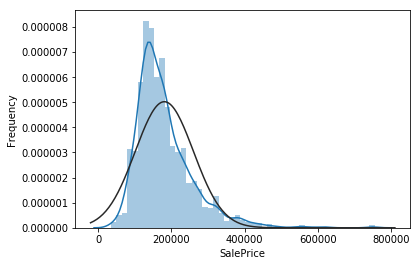

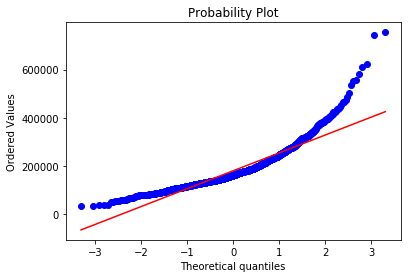

In [10]:
#Check to see if the target variable follows a normal distribution
sns.distplot(train['SalePrice'], fit = norm)
plt.ylabel('Frequency')
plt.show()

probplot(train['SalePrice'], plot=plt)
plt.show()

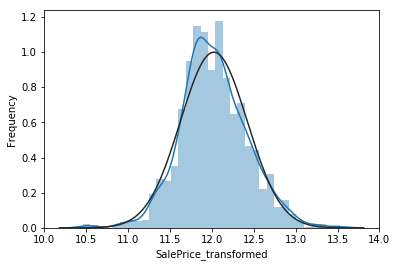

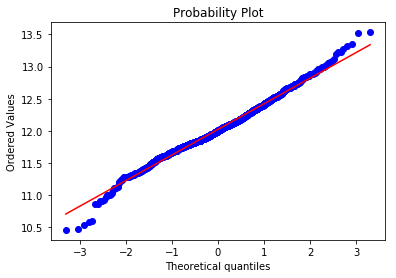

In [11]:
# Log transforming target column to resemble a normal distribution 
train["SalePrice_transformed"] = np.log1p(train["SalePrice"])
sns.distplot(train['SalePrice_transformed'], fit = norm)
plt.ylabel('Frequency')
plt.show()

probplot(train['SalePrice_transformed'], plot=plt)
plt.show()

In [34]:
#Get datatypes of columns
print("Datatypes of columns: ")
print(train.dtypes.value_counts())

print('\nNumber of columns with missing values is {}'.format(sum(train.isnull().sum(axis=0) != 0)))

Datatypes of columns: 
object     43
int64      34
float64     4
dtype: int64

Number of columns with missing values is 19


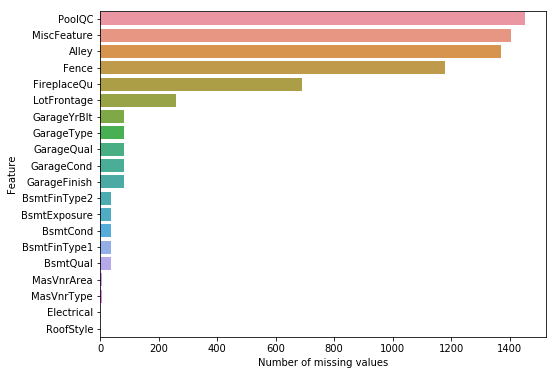

In [36]:
plt.figure(figsize=(8,6))
train_missing = train.isnull().sum(axis=0).sort_values(ascending=False).reset_index().head(20)
train_missing.columns = ['Feature', 'Number of missing values']
ax = sns.barplot(x="Number of missing values", y="Feature", data=train_missing)

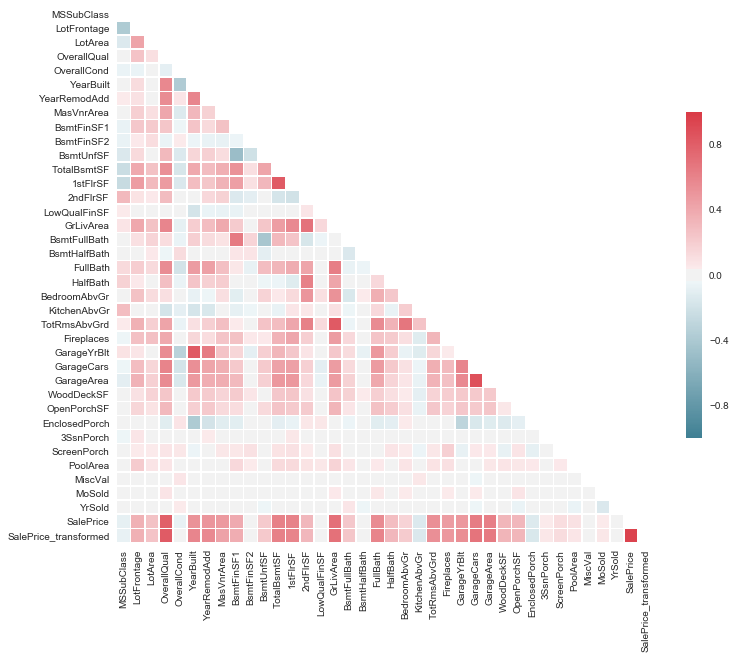

In [39]:
#Correlation among values
#Finding correlation
sns.set(style="white")
train_corr = train.corr()

mask = np.zeros_like(train_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (12,12))
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(train_corr, mask=mask, cmap=cmap, vmax=1, vmin = -1,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [92]:
#From the above correlation plot we see that OverallQual, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageCars, GarageArea

#train['SalePrice'].corr(train.loc[:,'GrLivArea'])
train['SalePrice'].corr(train.iloc[:,80])
#train.iloc[:,25]

0.9483743770902764

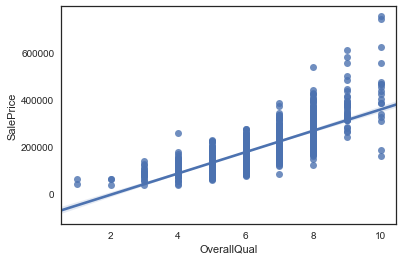

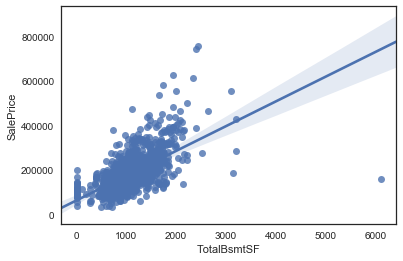

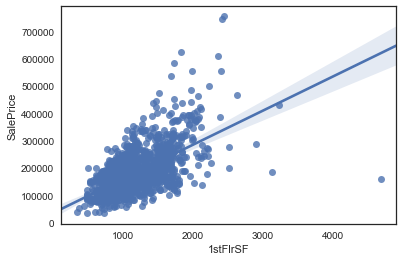

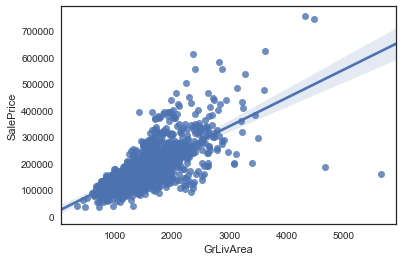

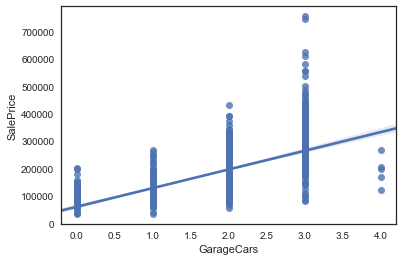

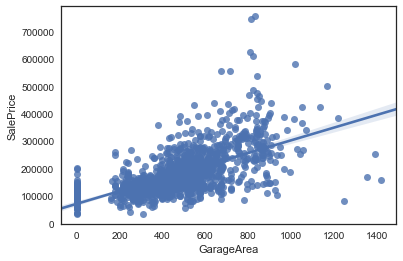

In [102]:
for i in range(train.shape[1]):
    if(train.iloc[:,i].dtype == 'int64' or train.iloc[:,i].dtype == 'float64'):
        if(abs(train['SalePrice'].corr(train.iloc[:,i])) >= 0.6 and abs(train['SalePrice'].corr(train.iloc[:,i])) <= 0.9):
            sns.regplot(train.iloc[:,i], train['SalePrice'])
            plt.show()